In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import numpy as np

torch.manual_seed(1)

#from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from gensim.models import KeyedVectors

## Load data
source is https://www.kaggle.com/c/word2vec-nlp-tutorial/data

In [2]:
data_path = '/Users/tyler/Documents/programming/pytorch_nlp/data/word2vec-nlp-tutorial/'

In [3]:
df = pd.read_csv(data_path+'labeledTrainData.tsv',sep='\t')

In [4]:
df.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [5]:
train = df[:15000]
val = df[15000:20000]
test = df[20000:]

In [6]:
len(train),len(val),len(test)

(15000, 5000, 5000)

In [7]:
def process_review(review):
    chars = ['/','\\','>','<','-','br']
    chars.extend('1 2 3 4 5 6 7 8 9 0'.split())
    for char in chars:
        review = review.replace(char,'')
    
    tokens = word_tokenize(review)
    tokens = [t.lower() for t in tokens]
    return tokens

## Make vocab and train data

In [8]:
labels = list(train.sentiment)
reviews = list(train.review.values)

all_words = [process_review(review) for review in tqdm(reviews)]

train_data = list(zip(all_words,labels))

In [9]:
flat_list = [item for sublist in all_words for item in sublist]
vocab = set(flat_list)

len(vocab)

word_to_idx = {word:idx for idx,word in enumerate(list(vocab))}

counts = Counter(flat_list)

In [10]:
counts = Counter(flat_list).most_common()

In [11]:
start = 10
keep = counts[start:20000+start]

In [12]:
keep[:5]

[('i', 52046), ('this', 45732), ('that', 44178), ("'s", 37794), ('was', 30368)]

In [13]:
vocab = [word for word,count in keep]
vocab.append('UNK')

In [14]:
word_to_idx = {word:idx for idx,word in enumerate(list(vocab))}
idx_to_word = {idx:word for word,idx in word_to_idx.items()}

## Make validation and test data

In [15]:
labels = list(test.sentiment)
reviews = list(test.review.values)

all_words = [process_review(review) for review in tqdm(reviews)]

test_data = list(zip(all_words,labels))

In [16]:
labels = list(val.sentiment)
reviews = list(val.review.values)

all_words = [process_review(review) for review in tqdm(reviews)]

val_data = list(zip(all_words,labels))

## Use pretained word vectors

In [18]:
path = '/Users/tyler/Documents/programming/embeddings/models/glove.840B.300d.model'
glove = KeyedVectors.load_word2vec_format(path,limit=100000)
weights = torch.FloatTensor(glove.vectors)

In [21]:
from torch.nn.utils.rnn import pad_sequence

In [525]:
a = torch.tensor([0,1],dtype=torch.float)
b = torch.tensor([.5,.5],dtype=torch.float)
loss_function(a,b)

tensor(13.8155)

In [498]:
weights.shape

torch.Size([100000, 300])

In [499]:
glove.index2word[5]

'of'

In [24]:
word2idx = {word:idx for idx,word in enumerate(glove.vocab.keys())}

In [22]:
def make_input(sentence, word2idx):
    vec = torch.zeros(len(word2idx),dtype=torch.long)
    for word in sentence:
        if word in word2idx:
            vec[word2idx[word]] = 1
    return vec.view(1, -1)

In [165]:
def make_padded_input(sentence, word2idx):
    max_len = 500
    vec = np.zeros((max_len,300))
    vec_idx = 0
    vec = []
    for word in sentence:
        if vec_idx < max_len:
            if word in glove:
                #vec[vec_idx] = glove[word]
                vec.append(glove[word])
                vec_idx += 1
    vec = np.vstack(vec)
    vec = vec.mean(axis=0)
    ten = torch.tensor(vec,dtype=torch.float)
    
    return ten

In [166]:
sentence = ', , this is a sentence asdf'.split()
x = make_padded_input(sentence, word2idx)

In [167]:
x.shape

torch.Size([300])

In [168]:
class glove_classifier(nn.Module):
    def __init__(self, num_labels, vocab_size, embedding_dim, hidden,glove,max_len):
        super(glove_classifier, self).__init__()
        self.linear = nn.Linear(embedding_dim * max_len, hidden)
        self.linear_2 = nn.Linear(hidden, num_labels)
        self.dropout = nn.Dropout(p=.3)

    def forward(self, inputs):
        x = inputs.view(1,-1)
        x = self.linear(x)
        #rint(x.shape)
        x = self.dropout(x)
        x = self.linear_2(x)
        x = self.dropout(x)
        #print(x.shape)
        return F.softmax((x), dim=1)[0]

In [169]:
NUM_LABELS = 2
VOCAB_SIZE = 100000
embedding_dim = 300
hidden = 100
max_len = 1

model = glove_classifier(NUM_LABELS, VOCAB_SIZE,embedding_dim,hidden,glove,max_len)

loss_function = nn.NLLLoss()
loss_function = nn.BCELoss()

lr = .001
#optimizer = optim.SGD(model.parameters(), lr=0.0001)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [170]:
sentence = ', , this is a sentence asdf'.split()
x = make_padded_input(sentence, word2idx)

In [171]:
model(x)

tensor([0.5294, 0.4706], grad_fn=<SelectBackward>)

In [172]:
len(val_data)

5000

In [173]:
save_path = 'model_checkpoints/glove_classifier.pt'
val_loss_min = np.Inf
#val_loss_min = 0.694
num_epochs = 20
loss_history = []
for epoch in range(num_epochs):
    train_loss = []
    for sentence, label in train_data:
        model.zero_grad()

        vec = make_padded_input(sentence, word2idx)
        if label == 0:
            target = torch.tensor([1,0],dtype=torch.float)
        else:
            target = torch.tensor([0,1],dtype=torch.float)
        #target = torch.LongTensor([label])

        log_probs = model(vec)

        loss = loss_function(log_probs, target)
        #print(loss)
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())
        
    mean_train_loss = np.mean(train_loss)
    val_loss = []
    for sentence, label in val_data:
        model.eval()

        vec = make_padded_input(sentence, word2idx)
        if label == 0:
            target = torch.tensor([1,0],dtype=torch.float)
        else:
            target = torch.tensor([0,1],dtype=torch.float)
        #target = torch.LongTensor([label])

        log_probs = model(vec)
        pred = log_probs.argmax().detach().numpy()
        loss = loss_function(log_probs, target)

        val_loss.append(loss.item())
        
    mean_val_loss = np.mean(val_loss)
    
    loss_history.append((mean_train_loss,mean_val_loss))
    print(f'Epoch {epoch+1}/{num_epochs}: train loss of {mean_train_loss:.3f}, val loss of {mean_val_loss:.3f}')
    
    if mean_val_loss <= val_loss_min:
        print(f'Val loss decreased {val_loss_min:.3f} --> {mean_val_loss:.3f} saving model...')
        torch.save(model.state_dict(),save_path)
        val_loss_min = mean_val_loss


Epoch 1/20: train loss of 0.487, val loss of 0.374
Val loss decreased inf --> 0.374 saving model...
Epoch 2/20: train loss of 0.386, val loss of 0.376
Epoch 3/20: train loss of 0.373, val loss of 0.372
Val loss decreased 0.374 --> 0.372 saving model...
Epoch 4/20: train loss of 0.365, val loss of 0.368
Val loss decreased 0.372 --> 0.368 saving model...
Epoch 5/20: train loss of 0.361, val loss of 0.364
Val loss decreased 0.368 --> 0.364 saving model...
Epoch 6/20: train loss of 0.357, val loss of 0.361
Val loss decreased 0.364 --> 0.361 saving model...
Epoch 7/20: train loss of 0.354, val loss of 0.359
Val loss decreased 0.361 --> 0.359 saving model...
Epoch 8/20: train loss of 0.352, val loss of 0.357
Val loss decreased 0.359 --> 0.357 saving model...
Epoch 9/20: train loss of 0.350, val loss of 0.356
Val loss decreased 0.357 --> 0.356 saving model...
Epoch 10/20: train loss of 0.348, val loss of 0.355
Val loss decreased 0.356 --> 0.355 saving model...
Epoch 11/20: train loss of 0.347

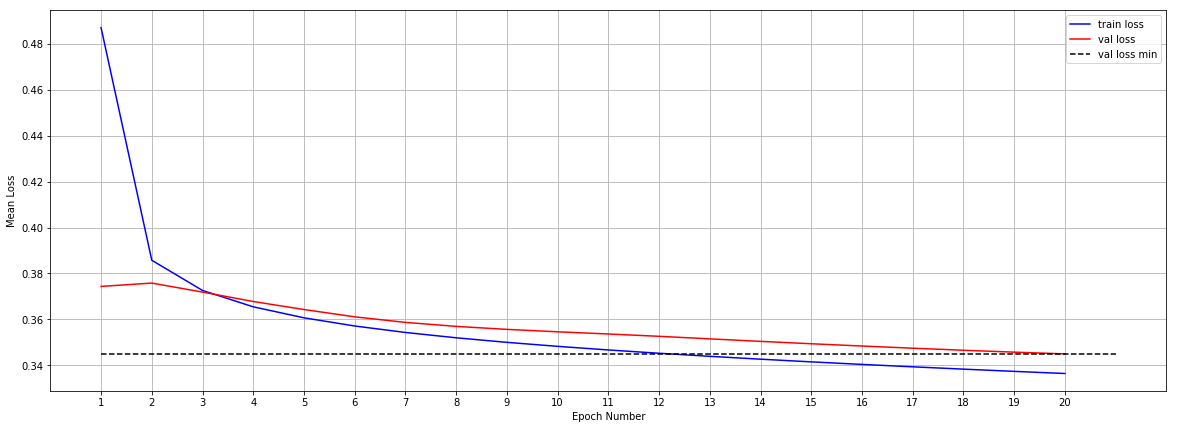

In [174]:
loss_array = np.array(loss_history)
train_loss = loss_array[:,0]
val_loss = loss_array[:,1]

x = np.arange(1,loss_array.shape[0]+1)
y = train_loss
plt.plot(x,y,c='blue',label='train loss')

x = np.arange(1,loss_array.shape[0]+1)
y = val_loss
plt.plot(x,y,c='red',label='val loss')

x0 = np.array([1,loss_array.shape[0]+1])
y0 = np.array([val_loss_min,val_loss_min])
plt.plot(x0,y0,c='black',label='val loss min',linestyle='--')

plt.grid(which='both') 
plt.legend()
fig,ax = plt.gcf(),plt.gca()
ax.set_xticks(x)
ax.set_xlabel('Epoch Number')
ax.set_ylabel('Mean Loss')

fig.set_size_inches(20,7)

## Evaluate Model

In [175]:
names = 'train val test'.split()
num = 100
#data_list = [train_data[:num],val_data[:num],test_data[:num]]
data_list = [train_data,val_data,test_data]

for name,data in zip(names,data_list):
    eval_loss = []
    num_correct = 0
    to_eval = test_data
    for sentence, label in data:
        model.eval()

        vec = make_padded_input(sentence, word2idx)        
        if label == 0:
            target = torch.tensor([1,0],dtype=torch.float)
        else:
            target = torch.tensor([0,1],dtype=torch.float)

        log_probs = model(vec)
        pred = log_probs.argmax().detach().numpy()
        correct = int(pred == label)
        num_correct += correct
        loss = loss_function(log_probs, target)

        eval_loss.append(loss.item())
    
    mean_loss = np.mean(eval_loss)
    print(f'----{name} set----'.upper())
    print(f'{name} loss of {round(mean_loss,3)}')
    print(f'{name} accuracy of {round(num_correct*100/len(data),2)}')


----TRAIN SET----
train loss of 0.341
train accuracy of 85.95
----VAL SET----
val loss of 0.345
val accuracy of 85.68
----TEST SET----
test loss of 0.356
test accuracy of 84.68
